## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle as pkl

In [3]:
df = pd.read_pickle('df_train_api.pk')

In [4]:
df.head()

,groups,type,data,label,coords
270,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[511.0, 143.0, 1217.0, 189.0, 864.0, 166.0]"
271,TAX INVOICE,"(tax invoic, text,text, 2337, 1653)",14754,0,"[717.0, 264.0, 877.0, 284.0, 797.0, 274.0]"
272,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[166.0, 351.0, 435.0, 369.0, 300.5, 360.0]"
273,"808, JANTA FLAT, GTB ENCLAVE, NANAD NAGARI","(number janta flat gtb enclav nanad nagari, nu...",14754,0,"[167.0, 384.0, 712.0, 403.0, 439.5, 393.5]"
274,DELHI-110093,"(delhi-110093, text, 2337, 1653)",14754,0,"[168.0, 417.0, 323.0, 436.0, 245.5, 426.5]"


In [5]:
df0 = df.query('label==0').sample(frac = 0.1)
df = df[df.label != 0]
df = pd.concat([df, df0], ignore_index=True)

In [6]:
X = df[['groups']]
X.head()

,groups
0,GS-032
1,22/08/2017
2,"Rs16,640"
3,N-10-01/2016-17
4,10-11-2017


In [7]:
y = df['label']
y.value_counts()/y.shape

0     0.632394
18    0.100000
2     0.100000
1     0.097183
14    0.039437
8     0.030986
Name: label, dtype: float64

In [8]:
from keras.preprocessing.text import Tokenizer
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, )
tokenizer.fit_on_texts(X['groups'].values)

X = tokenizer.texts_to_sequences(X['groups'].values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=40)


/home/jatin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=10)

In [11]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

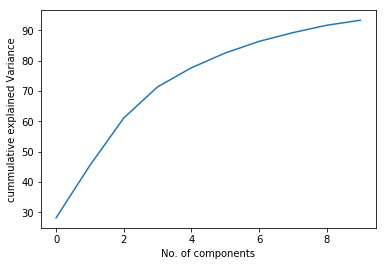

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [13]:
X_pca = pca.transform(X)

In [14]:
X_pca.shape

(710, 10)

## Train test split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.25, random_state = 42)

## Evaluation function

In [16]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [17]:
def print_score(clf, X_train, X_test, y_train, y_test, train = True):
#     print accuracy score, classification report, confusion metrics
    if train:
#         training performance
        print('Train Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_train, clf.predict(X_train))))
        print('Classification Report : \n {} \n'.format(classification_report(y_train, clf.predict(X_train))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_train, clf.predict(X_train))))
        
        res = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
        print('Average Accuracy : {0:.4f}\n'.format(np.mean(res)))
        print('Accuracy SD : {0:.4f}\n'.format(np.std(res)))
        
    elif train == False:
#         test performance
        print('Test Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_test, clf.predict(X_test))))
        print('Classification Report : \n {}\n'.format(classification_report(y_test, clf.predict(X_test))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_test, clf.predict(X_test))))


## Decision Tree

In [18]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [19]:
dt_clf = DecisionTreeClassifier()

In [20]:
params = {'min_samples_split': range(2, 20),
          'min_samples_leaf': range(2, 10),
          'criterion': ['entropy', 'gini'],
          'max_depth': [5, 10, 15, 20]}

In [21]:
clf = GridSearchCV(dt_clf, param_grid=params, cv=10)

In [22]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(2, 20), 'min_samples_leaf': range(2, 10), 'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.8778

Classification Report : 
              precision    recall  f1-score   support

          0       0.92      0.98      0.95       348
          1       0.95      0.82      0.88        51
          2       0.69      0.90      0.78        50
          8       0.50      0.53      0.52        15
         14       0.67      0.12      0.20        17
         18       0.85      0.57      0.68        51

avg / total       0.88      0.88      0.87       532
 

Confusion Metrics : 
 [[341   0   4   0   0   3]
 [  7  42   2   0   0   0]
 [  4   0  45   0   0   1]
 [  4   0   2   8   1   0]
 [  3   0   6   5   2   1]
 [ 11   2   6   3   0  29]] 

Average Accuracy : 0.7333

Accuracy SD : 0.0582

Test Result : 

Accuracy Score 0.6854

Classification Report : 
              precision    recall  f1-score   support

          0       0.75      0.92      0.83       101
          1       0.64      0.39      0.48        18
          2       0.50      0.62      0.55  

In [24]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=12,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Using Bagging Classifier

In [28]:
bag_clf = BaggingClassifier()
params = {'base_estimator': [DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=10, min_samples_leaf=5), RandomForestClassifier()],
          'n_estimators': [100, 200]}

In [29]:
clf = GridSearchCV(bag_clf, param_grid=params, cv=10)

In [30]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight...ore=False, random_state=None, verbose=0,
            warm_start=False)], 'n_estimators': [100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
clf.best_estimator_

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=200, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [32]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9568

Classification Report : 
              precision    recall  f1-score   support

          0       0.97      0.99      0.98       348
          1       0.93      0.98      0.95        51
          2       0.94      0.92      0.93        50
          8       1.00      0.73      0.85        15
         14       0.88      0.88      0.88        17
         18       0.96      0.86      0.91        51

avg / total       0.96      0.96      0.96       532
 

Confusion Metrics : 
 [[343   4   1   0   0   0]
 [  1  50   0   0   0   0]
 [  3   0  46   0   0   1]
 [  2   0   0  11   2   0]
 [  0   0   1   0  15   1]
 [  6   0   1   0   0  44]] 

Average Accuracy : 0.7859

Accuracy SD : 0.0333

Test Result : 

Accuracy Score 0.7360

Classification Report : 
              precision    recall  f1-score   support

          0       0.75      0.97      0.84       101
          1       0.82      0.50      0.62        18
          2       0.50      0.48      0.49  

## Using Random forest

In [33]:
rf_clf = RandomForestClassifier()
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [5, 10, 15],
          'min_samples_split': range(2,10),
          'min_samples_leaf': range(2, 10)}

In [34]:
clf = GridSearchCV(rf_clf, param_grid=params, cv = 10)

In [35]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15], 'min_samples_split': range(2, 10), 'min_samples_leaf': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9380

Classification Report : 
              precision    recall  f1-score   support

          0       0.96      0.99      0.97       348
          1       0.96      0.90      0.93        51
          2       0.87      0.96      0.91        50
          8       0.82      0.60      0.69        15
         14       0.86      0.71      0.77        17
         18       0.91      0.78      0.84        51

avg / total       0.94      0.94      0.94       532
 

Confusion Metrics : 
 [[344   2   1   0   0   1]
 [  3  46   0   1   0   1]
 [  0   0  48   0   1   1]
 [  3   0   2   9   1   0]
 [  1   0   2   1  12   1]
 [  9   0   2   0   0  40]] 

Average Accuracy : 0.7803

Accuracy SD : 0.0319

Test Result : 

Accuracy Score 0.7472

Classification Report : 
              precision    recall  f1-score   support

          0       0.76      0.95      0.84       101
          1       0.69      0.50      0.58        18
          2       0.58      0.52      0.55  

In [37]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Random Forest 

In [142]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5, min_samples_split=6)

In [143]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [144]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.8722

Classification Report : 
              precision    recall  f1-score   support

          0       0.93      0.97      0.95       348
          1       0.79      0.88      0.83        51
          2       0.69      0.82      0.75        50
          8       0.80      0.27      0.40        15
         14       0.55      0.35      0.43        17
         18       0.86      0.61      0.71        51

avg / total       0.87      0.87      0.86       532
 

Confusion Metrics : 
 [[337   7   2   1   1   0]
 [  5  45   1   0   0   0]
 [  8   0  41   0   0   1]
 [  5   1   3   4   2   0]
 [  2   0   5   0   6   4]
 [  7   4   7   0   2  31]] 

Average Accuracy : 0.7595

Accuracy SD : 0.0482

Test Result : 

Accuracy Score 0.7303

Classification Report : 
              precision    recall  f1-score   support

          0       0.81      0.95      0.88       101
          1       0.56      0.56      0.56        18
          2       0.50      0.67      0.57  

## ADABoost

In [201]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5, min_samples_split=6), learning_rate=4.5, n_estimators=20)

In [202]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=4.5, n_estimators=20, random_state=None)

In [203]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.7914

Classification Report : 
              precision    recall  f1-score   support

          0       0.89      0.87      0.88       348
          1       0.90      0.75      0.82        51
          2       0.63      0.72      0.67        50
          8       0.50      0.67      0.57        15
         14       0.50      0.59      0.54        17
         18       0.48      0.49      0.49        51

avg / total       0.80      0.79      0.79       532
 

Confusion Metrics : 
 [[302   4  17   4   0  21]
 [  7  38   0   0   0   6]
 [  3   0  36   4   7   0]
 [  4   0   0  10   1   0]
 [  5   0   1   1  10   0]
 [ 20   0   3   1   2  25]] 

Average Accuracy : 0.6111

Accuracy SD : 0.0810

Test Result : 

Accuracy Score 0.5955

Classification Report : 
              precision    recall  f1-score   support

          0       0.75      0.77      0.76       101
          1       0.62      0.44      0.52        18
          2       0.27      0.33      0.30  